In [1]:
# Import packages
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import warnings

import numpy as np
from scipy import ndimage as ndi
from skimage.filters import sobel_h
from skimage.filters import sobel_v
from skimage.measure import label
from skimage.measure import regionprops
from skimage.transform import resize
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import random_channel_shift
from tensorflow.python.keras.preprocessing.image import apply_transform
from tensorflow.python.keras.preprocessing.image import flip_axis
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from deepcell.utils.transform_utils import transform_matrix_offset_center
from deepcell.utils.transform_utils import distance_transform_2d
from deepcell.image_generators import ImageFullyConvDataGenerator

In [2]:
# Define discriminative generator

class DiscDataGenerator(ImageFullyConvDataGenerator):
    def __init__(self,
             featurewise_center=False,
             samplewise_center=False,
             featurewise_std_normalization=False,
             samplewise_std_normalization=False,
             rotation_range=0.,
             width_shift_range=0.,
             height_shift_range=0.,
             shear_range=0.,
             zoom_range=0.,
             channel_shift_range=0.,
             fill_mode='nearest',
             cval=0.,
             horizontal_flip=False,
             vertical_flip=False,
             rescale=None,
             preprocessing_function=None,
             data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('`data_format` should be `"channels_last"` (channel after row and '
                             'column) or `"channels_first"` (channel before row and column). '
                             'Received arg: {}'.format(data_format))
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        elif data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or a tuple or list of two floats. '
                             'Received arg: {}'.format(zoom_range))

    def flow(self, train_dict, batch_size=1, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='png'):
        return DiscIterator(
            train_dict, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)



In [3]:
class DiscIterator(Iterator):
    def __init__(self, train_dict, image_data_generator,
                 batch_size=1, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(train_dict['X'], dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `DiscIterator` should have rank 4. '
                             'You passed an array with shape {}'.format(self.x.shape))

        self.channel_axis = -1 if data_format == 'channels_last' else 1
        self.y = train_dict['y']
        self.max_label = 0
        for batch in range(self.y.shape[0]):
            label_matrix = label(self.y[batch,:,:,1])
            max_label= np.amax(label_matrix)
            if max_label > self.max_label:
                self.max_label = max_label
            
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(DiscIterator, self).__init__(self.x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]))
        if self.channel_axis == 1:
            batch_y = np.zeros(tuple([len(index_array), self.max_label + 1] + list(self.y.shape)[2:]))
        else:
            batch_y = np.zeros(tuple([len(index_array)] + list(self.y.shape)[1:3] + [self.max_label + 1]))

        for i, j in enumerate(index_array):
            x = self.x[j]

            if self.y is not None:
                y = self.y[j]
                x, y = self.image_data_generator.random_transform(x.astype(K.floatx()), y)
            else:
                x = self.image_data_generator.random_transform(x.astype(K.floatx()))

            x = self.image_data_generator.standardize(x)

            if self.channel_axis == 1:
                interior = y[1, :, :]
            else:
                interior = y[:, :, 1]
                
            label_matrix = label(interior)

            # convert to one hot notation
            if self.channel_axis == 1:
                y_shape = (self.max_label + 1, self.y.shape[2], self.y.shape[3])
            else:
                y_shape = (self.y.shape[1], self.y.shape[2], self.max_label + 1)

            y = np.zeros(y_shape)
            
            for label_val in range(self.max_label):
                if self.channel_axis == 1:
                    y[label_val,:,:] = label_matrix == label_val
                else:
                    y[:,:,label_val] = label_matrix == label_val    

            batch_x[i] = x
            batch_y[i] = y

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                # Save X batch
                img_x = np.expand_dims(batch_x[i, :, :, 0], -1)
                img = array_to_img(img_x, self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e4),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))

                if self.y is not None:
                    img_y = np.expand_dims(batch_y[i, :, :, 0], -1)
                    img = array_to_img(img_y, self.data_format, scale=True)
                    fname = 'y_{prefix}_{index}_{hash}.{format}'.format(
                        prefix=self.save_prefix,
                        index=j,
                        hash=np.random.randint(1e4),
                        format=self.save_format)
                    img.save(os.path.join(self.save_to_dir, fname))

        if self.y is None:
            return batch_x
        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        # Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

In [4]:
import os
import errno
from deepcell import get_image_sizes
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell import bn_multires_feature_net

import numpy as np
from tensorflow.python.keras.optimizers import SGD,Adam
from tensorflow.python.keras import backend as K

# data options
DATA_OUTPUT_MODE = 'conv'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 256

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/unspecified_nuclear_data/nuclei/'
DATA_FILE = 'disc_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
file_name_save = os.path.join(NPZ_DIR, PREFIX, DATA_FILE)
num_of_features = 2 # Specify the number of feature masks that are present
window_size = (30, 30) # Size of window around pixel
training_direcs = ['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8', 'set9']
channel_names = ['nuclear']
raw_image_direc = ''
annotation_direc = ''

# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    max_training_examples=1e6, # Define maximum number of training examples
    window_size_x=window_size[0],
    window_size_y=window_size[1],
    border_mode=BORDER_MODE,
    file_name_save=file_name_save,
    training_direcs=training_direcs,
    channel_names=channel_names,
    num_of_features=num_of_features,
    raw_image_direc=raw_image_direc,
    annotation_direc=annotation_direc,
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE,
    display=False,
    verbose=True)


Reshaped feature data from (9, 1080, 1280, 3) to (225, 256, 256, 3)
Reshaped training data from (9, 1080, 1280, 1) to (225, 256, 256, 1)
Number of features: 3
Number of training data points: 14745600
Class weights: [9.65855499 3.88487025 0.37892337]


In [23]:
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

class_weights = training_data['class_weights']
X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

n_epoch = 100
batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

model_args = {
}

data_format = K.image_data_format()
row_axis = 2 if data_format == 'channels_first' else 1
col_axis = 3 if data_format == 'channels_first' else 2
channel_axis = 1 if data_format == 'channels_first' else 3

the_model = bn_multires_feature_net

size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if data_format == 'channels_first':
    model_args['input_shape'] = (X.shape[channel_axis], size[0], size[1])
else:
    model_args['input_shape'] = (size[0], size[1], X.shape[channel_axis])
model_args['n_features'] = 3
model_args['location'] = True

seg_model = the_model(**model_args)

X.shape: (225, 256, 256, 1)
y.shape: (225, 256, 256, 3)


In [24]:
# Train with disc loss

import numpy as np
import datetime
import tensorflow as tf
from skimage.external import tifffile as tiff
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import to_categorical as keras_to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from deepcell.utils.io_utils import get_images_from_directory
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.transform_utils import to_categorical
from deepcell.settings import CHANNELS_FIRST

dataset = DATA_FILE
expt = ''
it = 0
n_epoch = 10
lr_sched = rate_scheduler(lr = 0.01, decay=0.95)
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
training_data_file_name = os.path.join(direc_data, dataset + '.npz')
todays_date = datetime.datetime.now().strftime('%Y-%m-%d')

file_name_save = os.path.join(direc_save, '{}_{}_{}_{}.h5'.format(todays_date, dataset, expt, it))
file_name_save_loss = os.path.join(direc_save, '{}_{}_{}_{}.npz'.format(todays_date, dataset, expt, it))

train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='conv')

test_dict = {
    'X':X_test,
    'y':y_test,
    'class_weights':train_dict['class_weights'],
    'win_x':train_dict['win_x'],
    'win_y':train_dict['win_y']
}

class_weights = train_dict['class_weights']
n_classes = seg_model.layers[-1].output_shape[1 if CHANNELS_FIRST else -1]
# the data, shuffled and split between train and test sets
print('X_train shape:', train_dict['X'].shape)
print('y_train shape:', train_dict['y'].shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Output Shape:', seg_model.layers[-1].output_shape)
print('Number of Classes:', n_classes)

def discriminative_instance_loss(y_true, y_pred, delta_v=0.5, delta_d=1.5, order=2, gamma=1e-3):
    def temp_norm(ten, axis=-1):
        return tf.sqrt(K.epsilon() + tf.reduce_sum(tf.square(ten), axis=axis))

    # Compute variance loss
    cells_summed = tf.tensordot(y_true, y_pred, axes=[[0, 1, 2], [0, 1, 2]])
    n_pixels = tf.cast(tf.count_nonzero(y_true, axis=[0, 1, 2]), dtype=K.floatx()) + K.epsilon()
    n_pixels_expand = tf.expand_dims(n_pixels, axis=1) + K.epsilon()
    mu = tf.divide(cells_summed, n_pixels_expand)
    
    mu_tensor = tf.tensordot(y_true, mu, axes=[[-1], [0]])
    L_var_1 = y_pred - mu_tensor
    L_var_2 = tf.square(tf.nn.relu(temp_norm(L_var_1, axis=-1) - tf.constant(delta_v, dtype=K.floatx())))
    L_var_3 = tf.tensordot(L_var_2, y_true, axes=[[0, 1, 2], [0, 1, 2]])
    L_var_4 = tf.divide(L_var_3, n_pixels)
    L_var = tf.reduce_mean(L_var_4)
    
    # Compute distance loss
    mu_a = tf.expand_dims(mu, axis=0)
    mu_b = tf.expand_dims(mu, axis=1)

    diff_matrix = tf.subtract(mu_b, mu_a)
    L_dist_1 = temp_norm(diff_matrix, axis=-1)
    L_dist_2 = tf.square(tf.nn.relu(tf.constant(2*delta_d, dtype=K.floatx()) - L_dist_1))
    diag = tf.constant(0, dtype=K.floatx()) * tf.diag_part(L_dist_2)
    L_dist_3 = tf.matrix_set_diag(L_dist_2, diag)
    L_dist = tf.reduce_mean(L_dist_3)

    # Compute regularization loss
    L_reg = gamma * temp_norm(mu, axis=-1)
    L =  L_var + L_dist + tf.reduce_mean(L_reg)
    
    return L

def loss_function(y_true, y_pred):
    return discriminative_instance_loss(y_true, y_pred)

seg_model.compile(loss=loss_function, optimizer=optimizer)

X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3


In [25]:
datagen = DiscDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen_test = DiscDataGenerator(
    rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [26]:
loss_history = seg_model.fit_generator(
    datagen.flow(train_dict, batch_size=batch_size),
    steps_per_epoch=train_dict['y'].shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=datagen_test.flow(test_dict, batch_size=batch_size),
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        ModelCheckpoint(file_name_save, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        LearningRateScheduler(lr_sched)
    ])

Epoch 1/10
201/202 [============================>.] - ETA: 0s - loss: 7.2474
Epoch 00001: val_loss improved from inf to 6.28778, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-09_disc_channels_last_conv__0.h5
202/202 [==============================] - 20s 100ms/step - loss: 7.2548 - val_loss: 6.2878
Epoch 2/10
201/202 [============================>.] - ETA: 0s - loss: 7.1969
Epoch 00002: val_loss improved from 6.28778 to 6.25978, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-09_disc_channels_last_conv__0.h5
202/202 [==============================] - 16s 81ms/step - loss: 7.1944 - val_loss: 6.2598
Epoch 3/10
201/202 [============================>.] - ETA: 0s - loss: 7.1830
Epoch 00003: val_loss improved from 6.25978 to 6.25670, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-09_disc_channels_last_conv__0.h5
202/202 [==============================] - 17s 82ms/step - loss: 7.1856 - val_loss: 6.2567
Epoch 4

In [27]:
test_images = seg_model.predict(X_test)

In [28]:
test_images.shape

(23, 256, 256, 3)

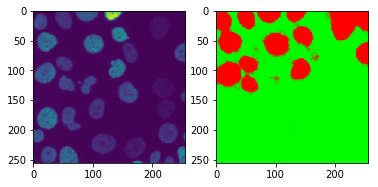

In [31]:
import matplotlib.pyplot as plt
index=1
plt.subplot(1,2,1)
plt.imshow(X_test[index,:,:,0])
plt.subplot(1,2,2)
# plt.imshow(test_images[index,:,:,1], cmap='jet')
plt.imshow(test_images[index,:,:,:])